In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
def plot(dataset):
    # Load the CSV data
    data = pd.read_csv('../acc_rate_csvs/' + dataset + '.csv')

    # Group by method and calculate mean and standard deviation for accuracy
    grouped = data.groupby('method')['acc'].agg(['mean', 'std']).reset_index()

    # Find the best ensemble method based on mean accuracy
    ensemble_methods = grouped[grouped['method'].str.startswith('ensemble')]
    best_ensemble = ensemble_methods.loc[ensemble_methods['mean'].idxmax()]

    # Plotting
    plt.figure(figsize=(8, 3))

    # Plot the best ensemble method
    plt.errorbar(best_ensemble['mean'], best_ensemble['method'], xerr=0.2*best_ensemble['std'], fmt='o', color='red',
                 capsize=5, capthick=2, elinewidth=2, label='Ensemble Method')

    # Plot other methods
    non_ensemble = grouped[~grouped['method'].str.startswith('ensemble')]
    for _, row in non_ensemble.iterrows():
        plt.errorbar(row['mean'], row['method'], xerr=0.2*row['std'], fmt='o', color='black', 
                     capsize=5, capthick=2, elinewidth=2, label='Previous Methods')

    # Add grid
    plt.grid(True, which='both', linestyle='--', linewidth=0.7)

    # Add labels and title
    plt.ylabel('Method')
    plt.xlabel('Accuracy')
    plt.title('Mean Accuracy and Standard Deviation of Each Method: ' + dataset)

    # Add legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    # Show plot
    plt.tight_layout()
    plt.show()

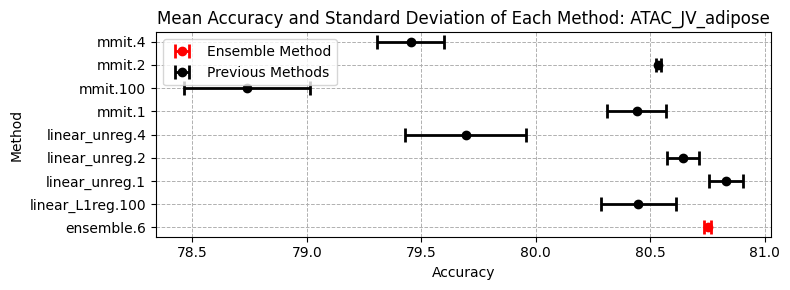

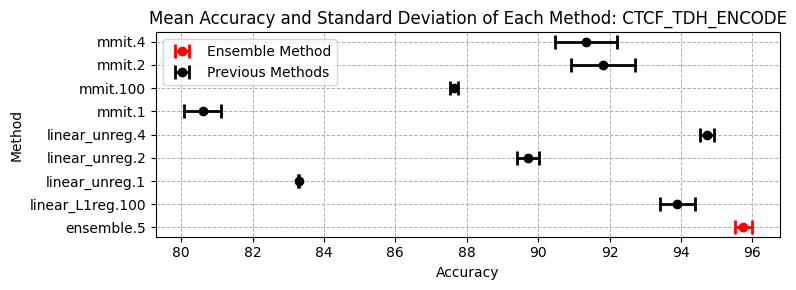

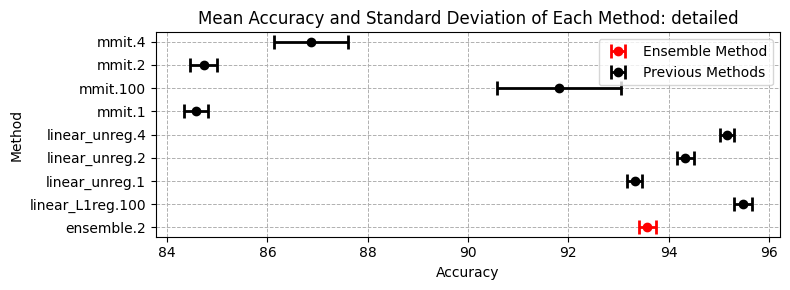

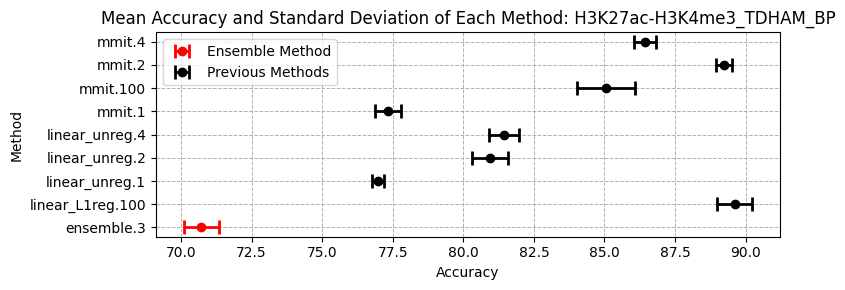

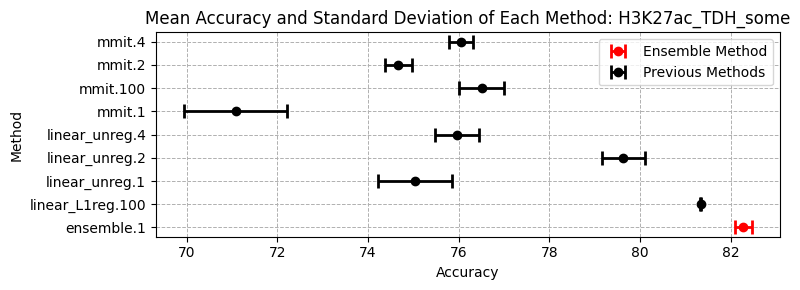

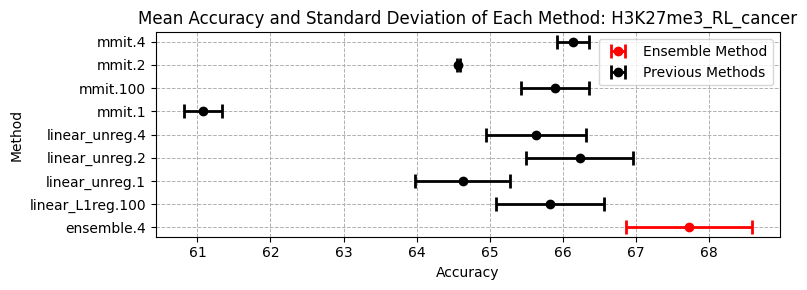

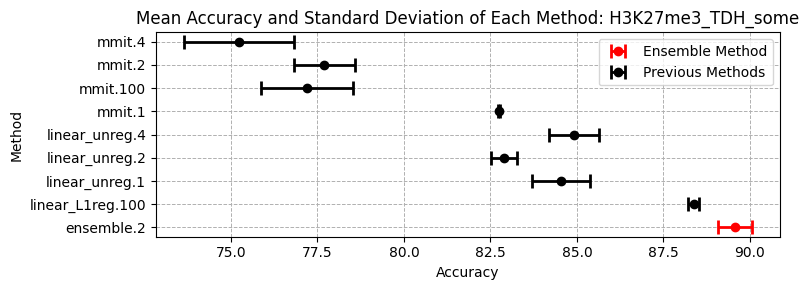

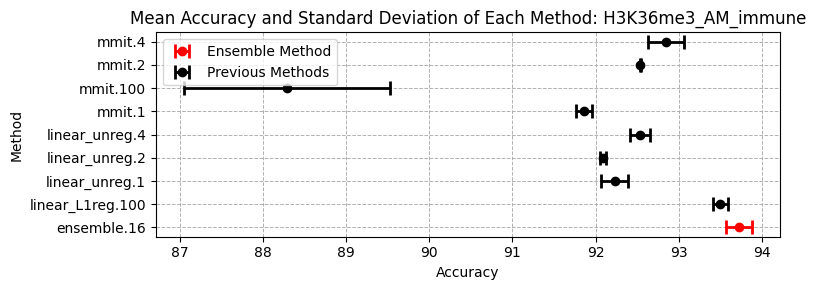

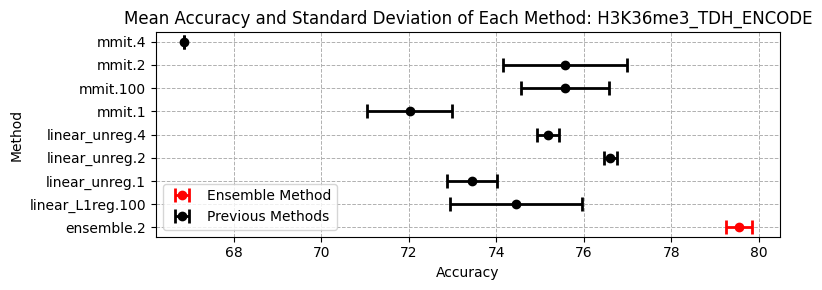

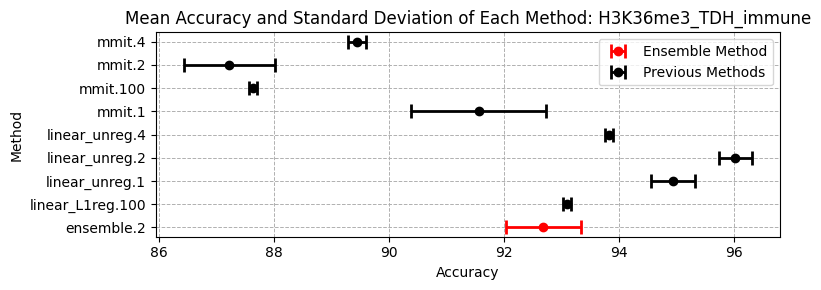

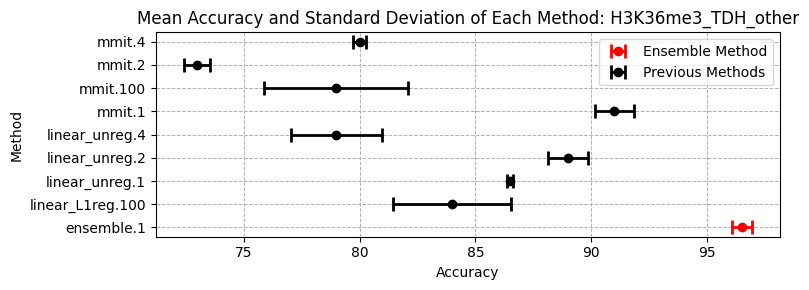

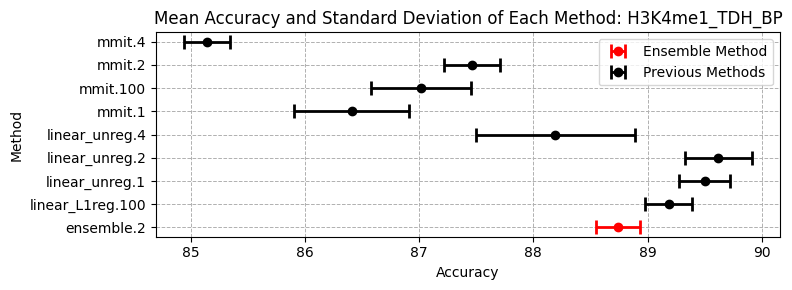

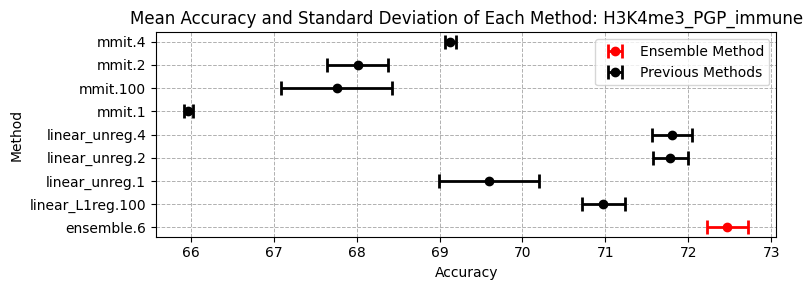

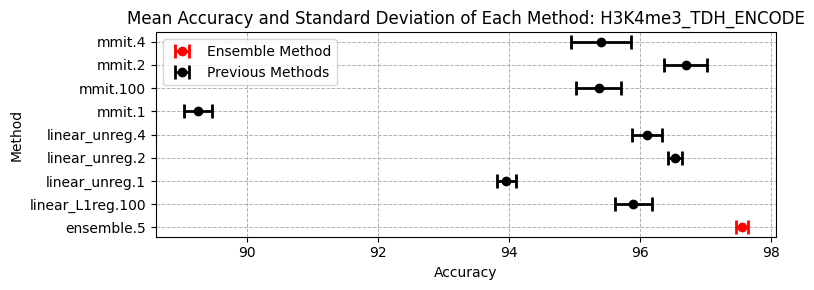

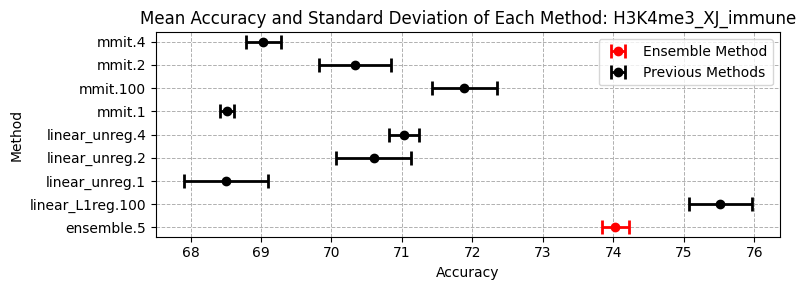

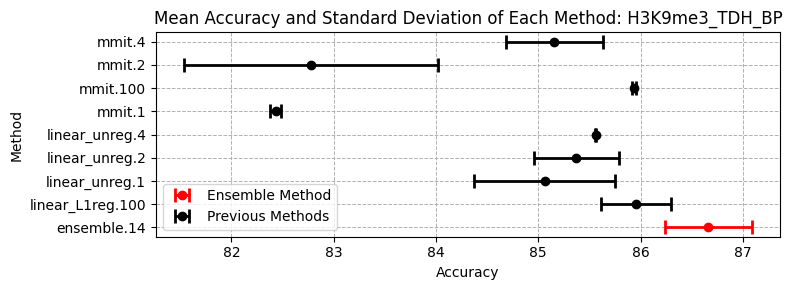

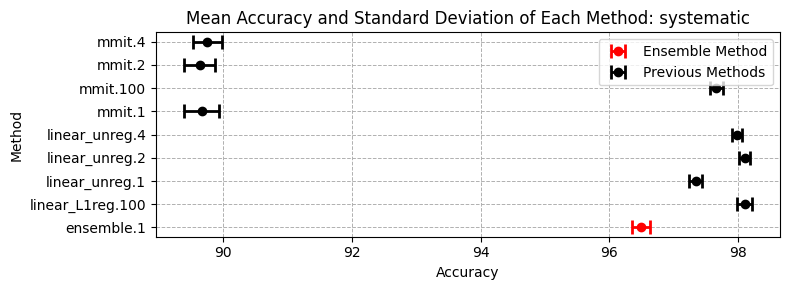

In [3]:
folder_path = '../training_data'
datasets = [name for name in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, name))]
for dataset in datasets:
    plot(dataset)